# Quantum Computing

## HHL Algorithm

### Problem Description:
The **HHL algorithm** is a quantum algorithm for solving systems of linear equations of the form:
$$
A \vec{x} = \vec{b}
$$
where:
- $A$ is a Hermitian matrix.
- $\vec{x}$ is the unknown vector.
- $\vec{b}$ is a known vector.

This example uses a simplified version of the HHL algorithm to solve a **linear system** using quantum methods like **Quantum Phase Estimation (QPE)** and **Quantum Fourier Transform (QFT)**. The goal is to demonstrate how quantum algorithms can be used to find $\vec{x}$ in a linear equation system, leveraging the capabilities of quantum computation.

### Key Concepts:
1. **Quantum Fourier Transform (QFT)**: A quantum analogue of the classical Fourier transform that is used in QPE to extract phase information.
2. **Quantum Phase Estimation (QPE)**: An algorithm that estimates the eigenvalues of a unitary operator, crucial for determining the eigenvalues of $A$.
3. **Controlled Rotations**: Adjust the quantum state amplitudes based on eigenvalues, effectively performing the division operation in the HHL algorithm.
4. **Inverse QFT**: Uncomputes the QFT to return the system to a state where measurements yield the solution.
5. **State Preparation**: The vector $\vec{b}$ is encoded into a quantum state $|b\rangle$.

### Quantum Algorithm Process:
1. **State Preparation**:
   - Encode $\vec{b}$ as a quantum state using a rotation gate.
2. **Quantum Phase Estimation (QPE)**:
   - Apply the QFT and controlled operations to estimate the eigenvalues of the matrix $A$.
3. **Controlled Rotation**:
   - Apply rotations based on the estimated eigenvalues to prepare for the inversion.
4. **Inverse QFT**:
   - Perform the inverse QFT to disentangle the quantum state, returning to the solution space.
5. **Measurement**:
   - Measure the resulting quantum state, which encodes the solution vector $\vec{x}$.

### Types of Quantum States:
1. **Logical Qubits**: Represent the solution space (e.g., the states corresponding to $|00\rangle$ and $|01\rangle$ for a 2-dimensional solution).
2. **Ancilla Qubits**: Used for intermediate calculations and quantum operations but are not part of the final solution.

### Quantum Solution Objective:
The goal is to find a **solution vector** $\vec{x}$ that satisfies the linear equation $A \vec{x} = \vec{b}$. The solution vector is derived from the measurement results of the quantum circuit, focusing on the probabilities of the logical qubit states.

### Steps:
1. **Define a Hermitian Matrix $A$**: Set up a simple Hermitian matrix $A$ for the problem.
2. **Prepare the Quantum Circuit**: Encode $\vec{b}$ into a quantum state and apply QPE and controlled rotations.
3. **Simulate the Quantum Circuit**: Use a quantum simulator to run the circuit and measure the results.
4. **Extract the Solution**: Focus on the relevant qubit states to extract the 2-dimensional solution vector $\vec{x}$.
5. **Normalize the Solution**: Normalize the solution vector to interpret the output as valid quantum state amplitudes.


In [ ]:
!pip install qiskit
!pip install qiskit-aer --upgrade

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
import numpy as np
from scipy.linalg import expm, block_diag

# Function to calculate the unitary matrix from a given Hermitian matrix
def calculate_unitary(matrix, t=1):
    if not np.allclose(matrix, matrix.conj().T):
        raise ValueError("Matrix is not Hermitian. Please provide a Hermitian matrix.")
    return expm(-1j * matrix * t)

# Function to embed an n x n matrix into a 2^k x 2^k unitary matrix
def embed_unitary(matrix):
    """
    Embed a square n x n unitary matrix into a 2^k x 2^k unitary matrix.
    Args:
        matrix (np.ndarray): The unitary matrix to embed.
    Returns:
        np.ndarray: A 2^k x 2^k unitary matrix with the original matrix embedded.
    """
    dim = matrix.shape[0]
    target_dim = 2**int(np.ceil(np.log2(dim)))
    if dim == target_dim:
        return matrix
    # Create an identity matrix of size (target_dim - dim)
    identity_extension = np.eye(target_dim - dim)
    # Create a block diagonal matrix to embed the original unitary
    embedded_matrix = block_diag(matrix, identity_extension)
    return embedded_matrix

# Function to create a controlled-U gate
def create_controlled_unitary(unitary, control_qubit, target_qubits):
    unitary_gate = UnitaryGate(unitary)
    controlled_unitary = unitary_gate.control(1)
    return controlled_unitary

# Prepare the initial state |b> based on a given vector
def prepare_b_state(qc, b, target_qubits):
    # Normalize the vector b
    norm_b = np.linalg.norm(b)
    b_normalized = b / norm_b

    # Pad b to match the nearest power of 2 dimension
    target_dim = 2**int(np.ceil(np.log2(len(b))))
    b_padded = np.pad(b_normalized, (0, target_dim - len(b_normalized)))

    # Initialize the state with the padded vector
    qc.initialize(b_padded, target_qubits)
    return qc


# Function to define the QFT
def qft(n):
    qft_circuit = QuantumCircuit(n)
    for qubit in range(n):
        qft_circuit.h(qubit)
        for j in range(qubit + 1, n):
            qft_circuit.cp(np.pi / 2**(j - qubit), j, qubit)
    for qubit in range(n // 2):
        qft_circuit.swap(qubit, n - qubit - 1)
    return qft_circuit

# Apply QPE using the provided unitary
def apply_qpe(qc, unitary, control_qubits, target_qubits):
    for i, control in enumerate(control_qubits):
        power = 2 ** i
        unitary_powered = np.linalg.matrix_power(unitary, power)
        controlled_gate = create_controlled_unitary(unitary_powered, control, target_qubits)
        qc.append(controlled_gate, [control] + target_qubits)
    qc.append(qft(len(control_qubits)).to_gate(), control_qubits)
    return qc

# Function to apply controlled rotation (using one control qubit)
def controlled_rotation(qc, control_qubit, target_qubit, angle=np.pi/4):
    qc.cry(angle, control_qubit, target_qubit)
    return qc

# Function to add the inverse QFT
def inverse_qft(n):
    return qft(n).inverse()

# Function to execute the quantum circuit and return results
def execute_quantum_circuit(qc, shots=1024):
    simulator = Aer.get_backend('qasm_simulator')
    transpiled_qc = transpile(qc, simulator)
    job = simulator.run(transpiled_qc, shots=shots)
    return job.result().get_counts()

# Function to normalize the solution vector from measured probabilities
def extract_solution_vector(counts, n):
    total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}
    # Extract relevant components for the n-dimensional solution
    solution_probabilities = {
        state[:int(np.log2(n))]: prob for state, prob in probabilities.items()
    }
    # Construct the solution vector by considering only relevant states
    solution_vector = np.array([solution_probabilities.get(f"{i:0{int(np.log2(n))}b}", 0) for i in range(n)])
    return solution_vector / np.linalg.norm(solution_vector)

# Main function to create the quantum circuit and solve A|x> = |b>
def solve_linear_system(A, b, num_qpe_qubits=3):
    n = len(A)
    if len(b) != n:
        raise ValueError("Vector b must have the same dimension as the matrix A.")

    # Embed the unitary matrix into a 2^k x 2^k space (e.g., 4x4 for 3x3)
    embedded_unitary_matrix = embed_unitary(calculate_unitary(A))

    qc = QuantumCircuit(num_qpe_qubits + int(np.log2(embedded_unitary_matrix.shape[0])))
    target_qubits = list(range(int(np.log2(embedded_unitary_matrix.shape[0]))))
    control_qubits = list(range(int(np.log2(embedded_unitary_matrix.shape[0])), num_qpe_qubits + int(np.log2(embedded_unitary_matrix.shape[0]))))

    prepare_b_state(qc, b, target_qubits)
    apply_qpe(qc, embedded_unitary_matrix, control_qubits, target_qubits)
    controlled_rotation(qc, control_qubits[-1], target_qubits[0])
    qc.append(inverse_qft(len(control_qubits)), control_qubits)

    qc.measure_all()
    print("Quantum Circuit:")
    print(qc.draw())

    counts = execute_quantum_circuit(qc)
    print("\nResults of the Quantum Circuit Execution:")
    print(counts)

    solution_vector = extract_solution_vector(counts, n)
    print("\nNormalized solution vector |x> representing the solution to A|x> = |b>:")
    print(solution_vector)
    return solution_vector

# Example usage for a 3x3 problem
A = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]])
b = np.array([1, 1, 1])
x = solve_linear_system(A, b)

Quantum Circuit:
        ┌────────────────────────────────────────┐┌──────────┐┌──────────┐»
   q_0: ┤0                                       ├┤0         ├┤0         ├»
        │  Initialize(0.57735,0.57735,0.57735,0) ││  Unitary ││  Unitary │»
   q_1: ┤1                                       ├┤1         ├┤1         ├»
        └────────────────────────────────────────┘└────┬─────┘└────┬─────┘»
   q_2: ───────────────────────────────────────────────■───────────┼──────»
                                                                   │      »
   q_3: ───────────────────────────────────────────────────────────■──────»
                                                                          »
   q_4: ──────────────────────────────────────────────────────────────────»
                                                                          »
meas: 5/══════════════════════════════════════════════════════════════════»
                                                                       

## Variational Quantum Eigensolver


Problem Description: Max-Cut Problem
The Max-Cut problem is a well-known NP-hard problem in graph theory. The objective is to partition the nodes
of a given graph into two subsets such that the sum of the weights of the edges between the subsets is maximized.
Formally, for a graph G = (V, E) with vertices V and edges E, and a weight function w(i, j) that assigns a weight
to each edge (i, j), the goal is to find a partition (S, T) of V such that the sum of weights of edges between
the sets S and T is maximized:
    
$
\text{Maximize: } \sum_{(i, j) \in E} w(i, j) \quad \text{where } i \in S \text{ and } j \in T.
$


In [ ]:
!pip install qiskit qiskit-nature --upgrade
!pip install qiskit_algorithms
!pip install pyscf
!pip install qiskit qiskit-aer qiskit-optimization qiskit_algorithms --upgrade



VQE Energy: -13.598327598363953
VQE Max-Cut Objective: -57.09832759836395
VQE Solution: [1 1 1 0 1 0 0 0]
VQE Solution Objective: 76.0

VQE-based Optimizer Solution:
objective function value: 76.0
variable values: x_0=1.0, x_1=1.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0
status: SUCCESS


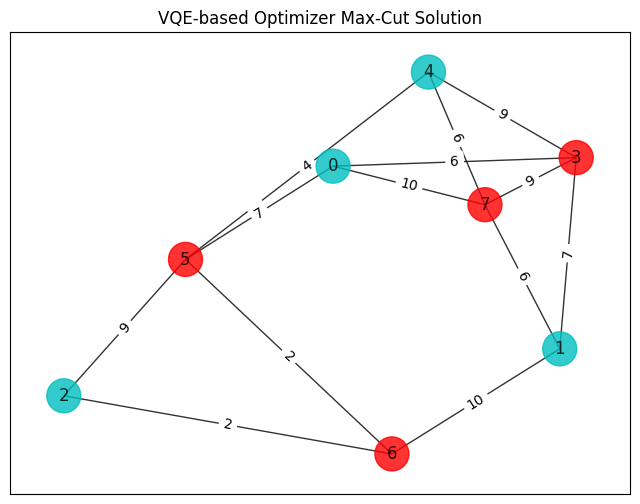

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import warnings

# Suppress specific deprecation warnings from Qiskit
warnings.filterwarnings("ignore", category=DeprecationWarning, module='qiskit.primitives')
warnings.filterwarnings("ignore", message="The function ``qiskit.primitives.utils.init_observable()`` is deprecated")

# Function to generate a random weighted graph
def generate_random_graph(n, p):
    """Generates an Erdős-Rényi random graph with n nodes and edge probability p.

    Each edge is assigned a random weight between 1 and 10.
    """
    G = nx.erdos_renyi_graph(n, p)
    for (u, v) in G.edges():
        G[u][v]["weight"] = np.random.randint(1, 11)  # Random weights between 1 and 10
    return G

# Function to compute the weight matrix from the generated graph
def compute_weight_matrix(G):
    """Extracts the weight matrix from the given graph G.

    The weight matrix represents the weights of edges between each pair of nodes.
    """
    n = len(G.nodes())
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = temp["weight"]
    return w

# Function to draw the graph with specified node colors
def draw_graph(G, colors, pos):
    """Draws the weighted graph G using the provided node colors and positions.

    Node colors represent different sets or partitions in the Max-Cut solution.
    """
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Function to solve the Max-Cut problem using classical optimization
def solve_max_cut_classically(max_cut, w):
    """Solves the Max-Cut problem using a classical solver.

    Converts the Max-Cut problem into a quadratic program and then into an Ising model.
    Uses an exact classical eigensolver to find the optimal solution.
    """
    qp = max_cut.to_quadratic_program()
    #print("Quadratic Program:")
    #print(qp.prettyprint())

    # Convert the problem into an Ising Hamiltonian for quantum computation
    qubitOp, offset = qp.to_ising()
    #print("\nOffset:", offset)
    #print("Ising Hamiltonian:")
    #print(str(qubitOp))

    # Solve using the exact classical eigensolver
    exact_solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    result = exact_solver.solve(qp)
    #print("\nExact Classical Solution:")
    #print(result.prettyprint())

    return qubitOp, offset, qp, result

# Function to solve the Max-Cut problem using VQE (Variational Quantum Eigensolver)
def solve_max_cut_vqe(qubitOp, offset, max_cut, qp, optimizer_reps=10, max_iter=500):
    """Solves the Max-Cut problem using the VQE algorithm.

    Uses a quantum variational form (ansatz) with SPSA optimization to approximate the solution.
    """
    # Define the variational form and optimizer for VQE
    optimizer = SPSA(maxiter=max_iter)
    ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=optimizer_reps, entanglement="full")

    # Construct the VQE solver with a quantum sampler
    vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

    # Run VQE to find the minimum eigenvalue of the Ising Hamiltonian
    vqe_result = vqe.compute_minimum_eigenvalue(qubitOp)
    x_vqe = max_cut.sample_most_likely(vqe_result.eigenstate)

    print("\nVQE Energy:", vqe_result.eigenvalue.real)
    print("VQE Max-Cut Objective:", vqe_result.eigenvalue.real + offset)
    print("VQE Solution:", x_vqe)
    print("VQE Solution Objective:", qp.objective.evaluate(x_vqe))

    return vqe, x_vqe, vqe_result

# Function to visualize the Max-Cut solution on the graph
def visualize_solution(G, solution, pos, title):
    """Visualizes the Max-Cut solution on the graph G.

    Colors nodes based on their assignment in the solution and displays the graph.
    """
    n = len(G.nodes())
    # Pad the solution with zeros if it's shorter than the number of nodes
    padded_solution = np.pad(solution, (0, max(0, n - len(solution))), mode='constant', constant_values=0)
    colors = ["r" if padded_solution[i] == 0 else "c" for i in range(n)]
    plt.figure(figsize=(8, 6))
    draw_graph(G, colors, pos)
    plt.title(title)
    plt.show()

# Main function to run the entire Max-Cut problem-solving process
def main():
    # Parameters for generating the graph and running the VQE
    n = 8  # Number of nodes in the graph
    p = 0.4  # Probability for edge creation in the Erdős-Rényi model
    optimizer_reps = 10
    max_iter = 500

    # Generate a random weighted graph and draw it
    G = generate_random_graph(n, p)
    pos = nx.spring_layout(G, seed=42)  # Consistent layout for visualization
    colors = ["r" for node in G.nodes()]
    #draw_graph(G, colors, pos)

    # Compute the weight matrix from the graph
    w = compute_weight_matrix(G)

    # Define the Max-Cut problem from the weight matrix
    max_cut = Maxcut(w)

    # Solve the Max-Cut problem using a classical optimizer
    qubitOp, offset, qp, classical_result = solve_max_cut_classically(max_cut, w)
    classical_solution = max_cut.sample_most_likely(classical_result.x)
    #visualize_solution(G, classical_solution, pos, "Classical Max-Cut Solution")

    # Solve the Max-Cut problem using VQE
    vqe, x_vqe, vqe_result = solve_max_cut_vqe(qubitOp, offset, max_cut, qp, optimizer_reps, max_iter)
    #visualize_solution(G, x_vqe, pos, "VQE Max-Cut Solution")

    # Use the VQE-based optimizer to solve the quadratic program
    vqe_optimizer = MinimumEigenOptimizer(vqe)
    vqe_result_optimizer = vqe_optimizer.solve(qp)
    print("\nVQE-based Optimizer Solution:")
    print(vqe_result_optimizer.prettyprint())

    # Visualize the solution found by the VQE-based optimizer
    visualize_solution(G, vqe_result_optimizer.x, pos, "VQE-based Optimizer Max-Cut Solution")

# Run the main function when the script is executed
if __name__ == "__main__":
    main()